# 021: The Jansen-Rit Model

Modeling cortical columns and EEG rhythms with a three-population neural mass.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the three-population architecture of the Jansen-Rit model
- Explain how the sigmoid nonlinearity converts membrane potential to firing rate
- Simulate different EEG rhythms by adjusting parameters
- Identify parameter regimes for alpha oscillations, spike-wave, and irregular dynamics

## Prerequisites

- **Tutorial 000**: Getting Started with BrainMass
- **Tutorial 020**: Wilson-Cowan Model (E/I dynamics)
- Basic understanding of EEG signals and cortical rhythms

## Background / Theory

### The Jansen-Rit Model

The **Jansen-Rit model** (1995) describes the dynamics of a cortical column with three interacting neural populations:

1. **Pyramidal cells (M)**: Principal output neurons
2. **Excitatory interneurons (E)**: Provide excitatory feedback to pyramidal cells
3. **Inhibitory interneurons (I)**: Provide inhibitory feedback to pyramidal cells

### Circuit Architecture

```
External Input (p)
      |
      v
  [E: Excitatory] ---(C2)--> [M: Pyramidal] <---(C4)--- [I: Inhibitory]
      ^                           |                          ^
      |                           |                          |
      +---------(C1)--------------+-----------(C3)-----------+
```

### The Equations

Each population has two state variables: membrane potential and its derivative.

$$
\begin{aligned}
\dot{M} &= M_v \\
\dot{E} &= E_v \\
\dot{I} &= I_v \\
\dot{M}_v &= A_e b_e \cdot S(E - I + M_{inp}) - 2 b_e M_v - b_e^2 M \\
\dot{E}_v &= A_e b_e (E_{inp} + C a_2 \cdot S(C a_1 M)) - 2 b_e E_v - b_e^2 E \\
\dot{I}_v &= A_i b_i \cdot C a_4 \cdot S(C a_3 M + I_{inp}) - 2 b_i I_v - b_i^2 I
\end{aligned}
$$

### The Sigmoid Function

Maps membrane potential to firing rate:

$$
S(v) = \frac{s_{max}}{1 + e^{r(v_0 - v)}}
$$

| Parameter | Description | Default |
|-----------|-------------|----------|
| $s_{max}$ | Maximum firing rate | 5 Hz |
| $v_0$ | Half-activation threshold | 6 mV |
| $r$ | Sigmoid steepness | 0.56 |

### EEG Proxy

The EEG-like signal is the difference between excitatory and inhibitory postsynaptic potentials:

$$
EEG(t) = E(t) - I(t)
$$

### Key Parameters

| Parameter | Description | Default | Effect |
|-----------|-------------|---------|--------|
| $A_e$ | Excitatory gain | 3.25 mV | Amplitude of excitatory response |
| $A_i$ | Inhibitory gain | 22 mV | Amplitude of inhibitory response |
| $b_e$ | Excitatory rate | 100 Hz | Speed of excitatory dynamics |
| $b_i$ | Inhibitory rate | 50 Hz | Speed of inhibitory dynamics |
| $C$ | Connectivity constant | 135 | Overall coupling strength |

## Implementation

### Step 1: Setup and Imports

In [1]:
import brainmass
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set simulation time step (0.5 ms for Jansen-Rit)
brainstate.environ.set(dt=0.5 * u.ms)

In [2]:
def plot_jansen_rit(times, M, E, I, eeg, title):
    """Helper function to visualize Jansen-Rit dynamics."""
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    axes[0].plot(times, M, 'b-', linewidth=0.5)
    axes[0].set_ylabel('M (mV)')
    axes[0].set_title(title)
    
    axes[1].plot(times, E, 'g-', linewidth=0.5)
    axes[1].set_ylabel('E (mV)')
    
    axes[2].plot(times, I, 'r-', linewidth=0.5)
    axes[2].set_ylabel('I (mV)')
    
    axes[3].plot(times, eeg, 'k-', linewidth=0.5)
    axes[3].set_ylabel('EEG (mV)')
    axes[3].set_xlabel('Time (ms)')
    
    plt.tight_layout()
    plt.show()
    return fig

### Step 2: Alpha-Like Oscillations (Baseline)

With default parameters and moderate noisy input, the Jansen-Rit model produces alpha-like rhythms (8-12 Hz):

In [3]:
# Create Jansen-Rit node with default parameters
node = brainmass.JansenRitStep(1)
node.init_all_states()

# Print key parameters
print("Jansen-Rit parameters:")
print(f"  Ae = {node.Ae.value()}, Ai = {node.Ai.value()}")
print(f"  be = {node.be.value()}, bi = {node.bi.value()}")
print(f"  C = {node.C.value()}")

Jansen-Rit parameters:
  Ae = 3.25 * mvolt, Ai = 22.0 * mvolt
  be = 100.0 * hertz, bi = 50.0 * hertz
  C = 135.0


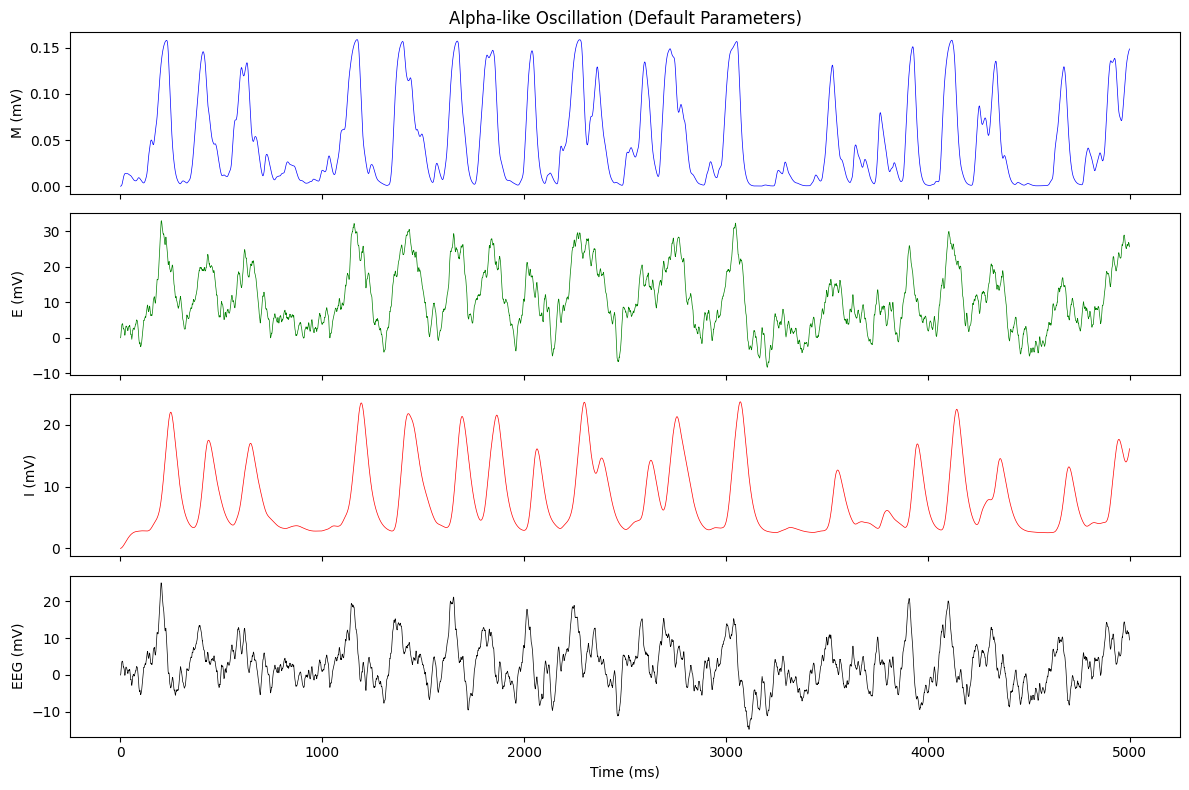

In [4]:
def step_run(inp):
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

# Simulation parameters
dt = brainstate.environ.get_dt()
duration = 5 * u.second
n_steps = int(duration / dt)
indices = np.arange(n_steps)

# Generate noisy input (mean 120 Hz, scaled noise)
noise_std = 30. / (float(dt / u.second) ** 0.5)  # Scale for dt-independent intensity
inputs = brainstate.random.normal(120., noise_std, indices.shape) * u.Hz

# Run simulation
data = brainstate.transform.for_loop(step_run, inputs)
M, E, I, eeg = data

# Plot
times = indices * dt
plot_jansen_rit(times, M[:, 0], E[:, 0], I[:, 0], eeg[:, 0], 'Alpha-like Oscillation (Default Parameters)');

### Step 3: Spectral Analysis

Verify the alpha rhythm in the frequency domain:

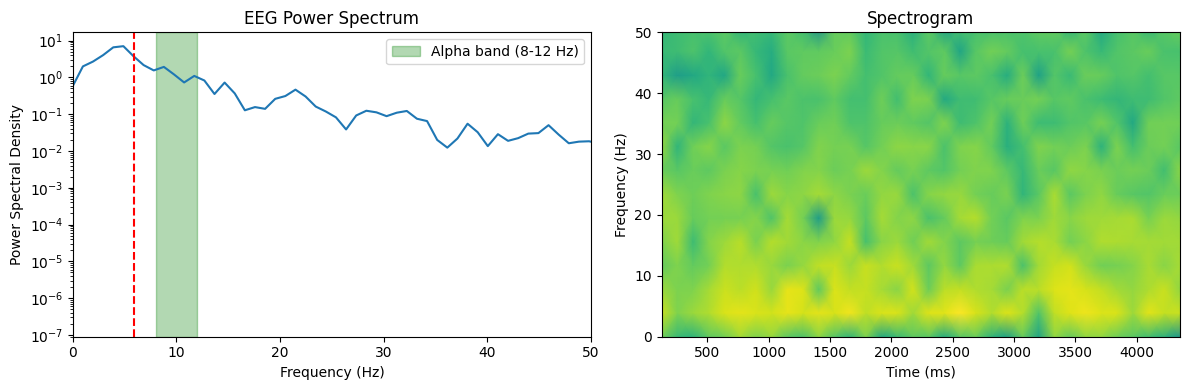

Peak frequency: 5.9 Hz


In [5]:
from scipy import signal

# Compute power spectrum
fs = 1000 / float(dt / u.ms)  # Sampling frequency in Hz
eeg_signal = np.array(u.get_magnitude(eeg[1000:, 0]))  # Discard transient, ensure numpy array
f, Pxx = signal.welch(eeg_signal, fs=fs, nperseg=2048)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Power spectrum
axes[0].semilogy(f, Pxx)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density')
axes[0].set_title('EEG Power Spectrum')
axes[0].set_xlim([0, 50])
axes[0].axvspan(8, 12, alpha=0.3, color='green', label='Alpha band (8-12 Hz)')
axes[0].legend()

# Peak frequency
peak_idx = np.argmax(Pxx[(f > 5) & (f < 30)]) + np.searchsorted(f, 5)
peak_freq = f[peak_idx]
axes[0].axvline(peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.1f} Hz')

# Time-frequency spectrogram
f_spec, t_spec, Sxx = signal.spectrogram(eeg_signal, fs=fs, nperseg=512, noverlap=256)
axes[1].pcolormesh(t_spec * 1000, f_spec, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_title('Spectrogram')
axes[1].set_ylim([0, 50])

plt.tight_layout()
plt.show()

print(f"Peak frequency: {peak_freq:.1f} Hz")

### Step 4: Sinusoidal Entrainment

The Jansen-Rit model can be entrained by periodic input:

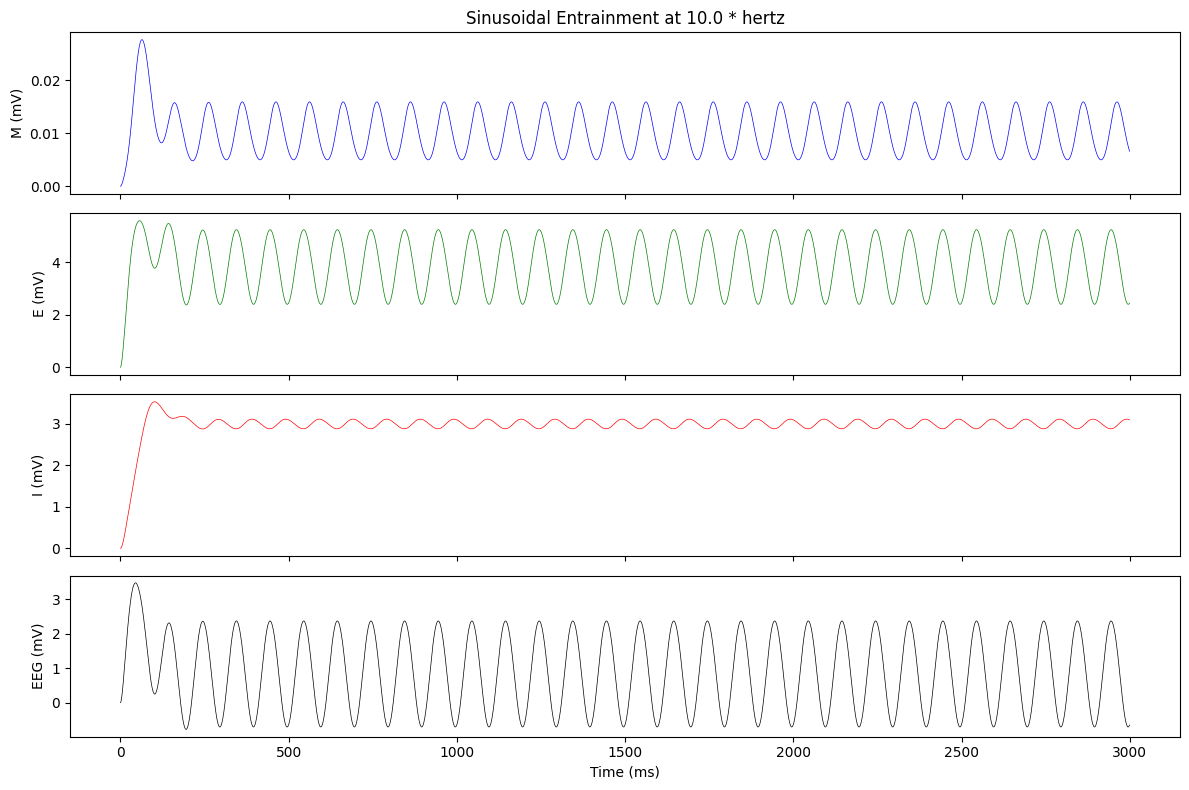

In [6]:
# Create fresh node
node = brainmass.JansenRitStep(1)
brainstate.nn.init_all_states(node)

# Entrainment frequency
f_drive = 10. * u.Hz

def step_driven(i):
    t = i * dt
    # Sinusoidal input: baseline + oscillation
    inp = (80. + 70. * u.math.sin(2 * u.math.pi * f_drive * t)) * u.Hz
    eeg = node.update(E_inp=inp)
    return node.M.value, node.E.value, node.I.value, eeg

# Simulate
dt = brainstate.environ.get_dt()
indices = np.arange(int(3 * u.second / dt))
data = brainstate.transform.for_loop(step_driven, indices)
M, E, I, eeg = data

# Plot
times = indices * dt
plot_jansen_rit(times, M[:, 0], E[:, 0], I[:, 0], eeg[:, 0], f'Sinusoidal Entrainment at {f_drive}');

### Step 5: Different Dynamical Regimes

By adjusting parameters, we can produce different EEG patterns:

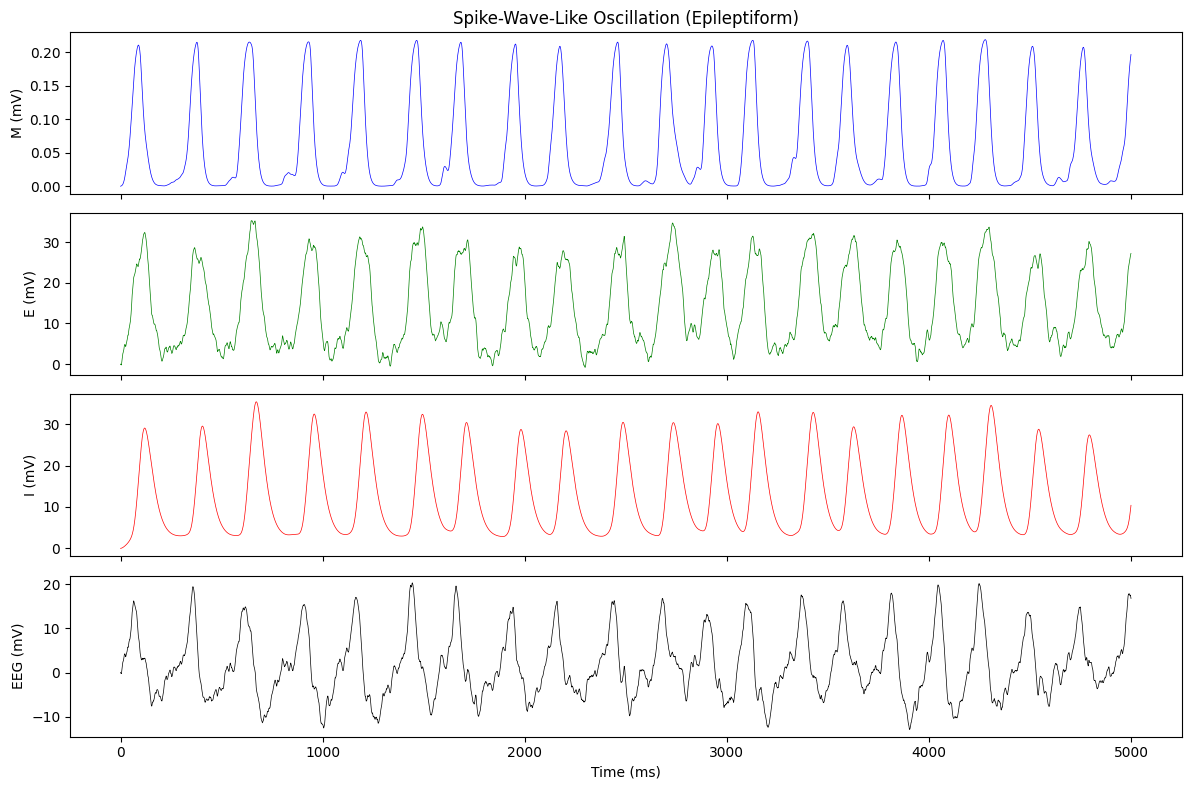

In [7]:
# Spike-wave-like regime (epileptiform)
node_sw = brainmass.JansenRitStep(
    1, 
    Ae=4.5 * u.mV,   # Increased excitatory gain
    Ai=18. * u.mV,   # Decreased inhibitory gain
    bi=40. * u.Hz    # Slower inhibition
)
brainstate.nn.init_all_states(node_sw)

def step_sw(inp):
    eeg = node_sw.update(E_inp=inp)
    return node_sw.M.value, node_sw.E.value, node_sw.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(5 * u.second / dt))
noise_std = 10. / (float(dt / u.second) ** 0.5)
inputs = brainstate.random.normal(90., noise_std, indices.shape) * u.Hz

data = brainstate.transform.for_loop(step_sw, inputs)
M, E, I, eeg = data

plot_jansen_rit(indices * dt, M[:, 0], E[:, 0], I[:, 0], eeg[:, 0], 
                'Spike-Wave-Like Oscillation (Epileptiform)');

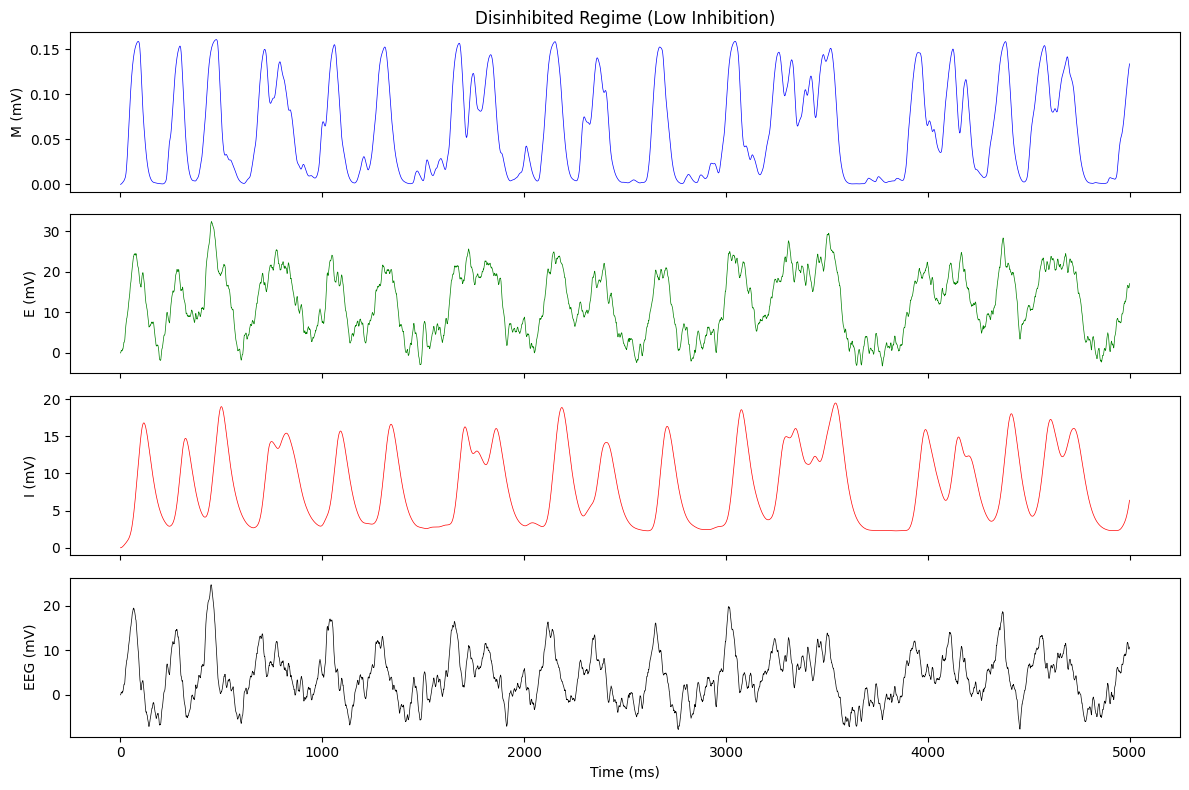

In [8]:
# Reduced inhibition regime
node_disin = brainmass.JansenRitStep(
    1,
    Ai=15. * u.mV,   # Reduced inhibitory gain
    bi=40. * u.Hz    # Slower inhibition
)
brainstate.nn.init_all_states(node_disin)

def step_disin(inp):
    eeg = node_disin.update(E_inp=inp)
    return node_disin.M.value, node_disin.E.value, node_disin.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(5 * u.second / dt))
noise_std = 20. / (float(dt / u.second) ** 0.5)
inputs = brainstate.random.normal(100., noise_std, indices.shape) * u.Hz

data = brainstate.transform.for_loop(step_disin, inputs)
M, E, I, eeg = data

plot_jansen_rit(indices * dt, M[:, 0], E[:, 0], I[:, 0], eeg[:, 0], 
                'Disinhibited Regime (Low Inhibition)');

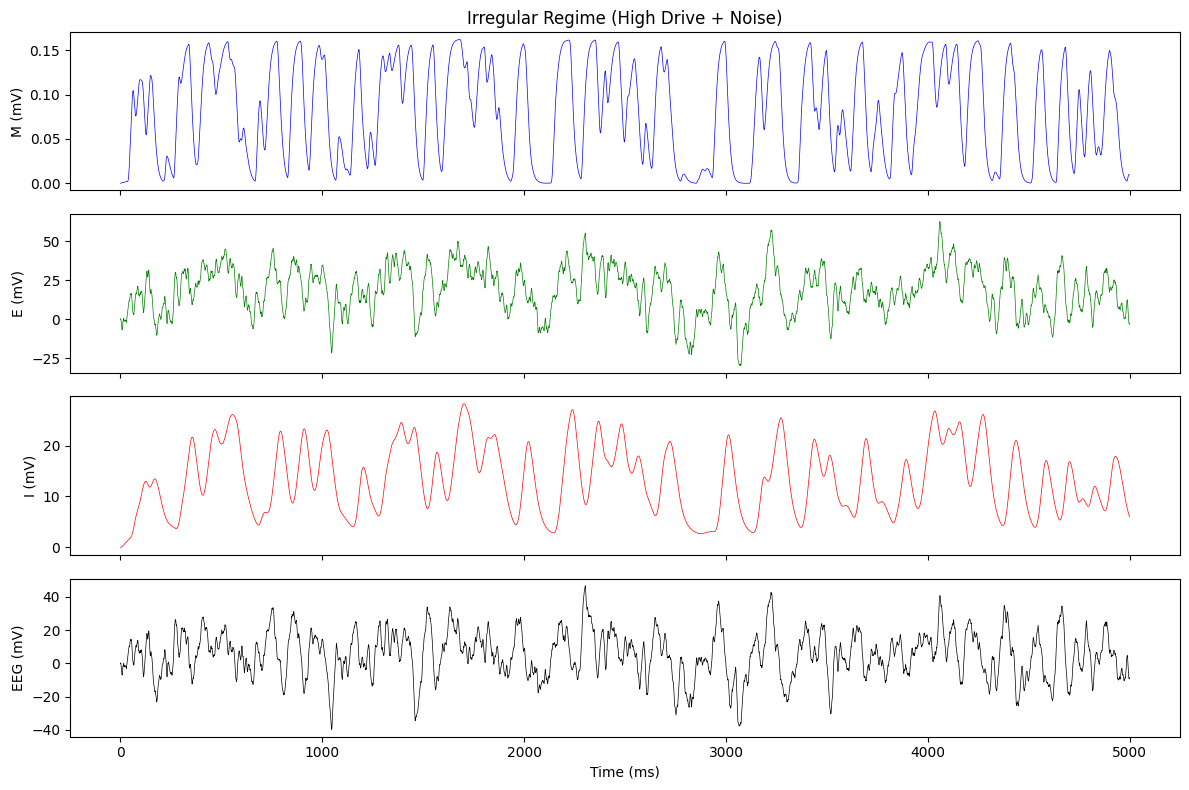

In [9]:
# Irregular/noisy regime (high drive)
node_irreg = brainmass.JansenRitStep(1)
brainstate.nn.init_all_states(node_irreg)

def step_irreg(inp):
    eeg = node_irreg.update(E_inp=inp)
    return node_irreg.M.value, node_irreg.E.value, node_irreg.I.value, eeg

dt = brainstate.environ.get_dt()
indices = np.arange(int(5 * u.second / dt))
noise_std = 80. / (float(dt / u.second) ** 0.5)
inputs = brainstate.random.normal(220., noise_std, indices.shape) * u.Hz

data = brainstate.transform.for_loop(step_irreg, inputs)
M, E, I, eeg = data

plot_jansen_rit(indices * dt, M[:, 0], E[:, 0], I[:, 0], eeg[:, 0], 
                'Irregular Regime (High Drive + Noise)');

### Step 6: Input-Driven Bifurcation

Sweep external input to reveal different dynamical regimes:

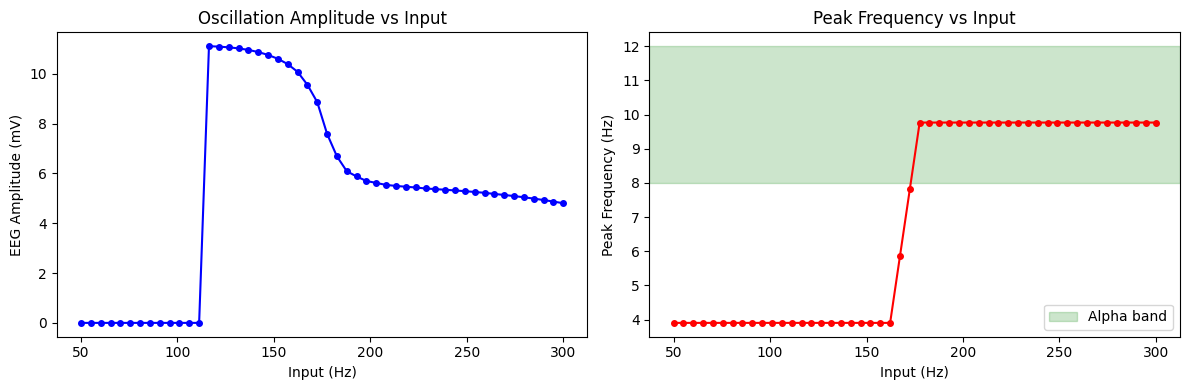

In [10]:
# Input values to sweep
E_inp_values = np.linspace(50, 300, 50) * u.Hz

peak_freqs = []
amplitudes = []

for E_inp in E_inp_values:
    node = brainmass.JansenRitStep(1)
    brainstate.nn.init_all_states(node)
    
    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return node.update(E_inp=E_inp)
    
    dt = brainstate.environ.get_dt()
    indices = np.arange(int(3 * u.second / dt))
    eeg = brainstate.transform.for_loop(step, indices)
    
    # Analyze steady-state
    eeg_ss = np.array(u.get_magnitude(eeg[2000:, 0]))
    amplitudes.append(eeg_ss.max() - eeg_ss.min())
    
    # Peak frequency
    fs = 1000 / float(dt / u.ms)
    f, Pxx = signal.welch(eeg_ss, fs=fs, nperseg=1024)
    peak_idx = np.argmax(Pxx[(f > 3) & (f < 40)])
    peak_freqs.append(f[(f > 3) & (f < 40)][peak_idx])

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(E_inp_values / u.Hz, amplitudes, 'b-o', markersize=4)
axes[0].set_xlabel('Input (Hz)')
axes[0].set_ylabel('EEG Amplitude (mV)')
axes[0].set_title('Oscillation Amplitude vs Input')

axes[1].plot(E_inp_values / u.Hz, peak_freqs, 'r-o', markersize=4)
axes[1].set_xlabel('Input (Hz)')
axes[1].set_ylabel('Peak Frequency (Hz)')
axes[1].set_title('Peak Frequency vs Input')
axes[1].axhspan(8, 12, alpha=0.2, color='green', label='Alpha band')
axes[1].legend()

plt.tight_layout()
plt.show()

### Step 7: E/I Gain Parameter Space

Explore how excitatory and inhibitory gains affect dynamics:

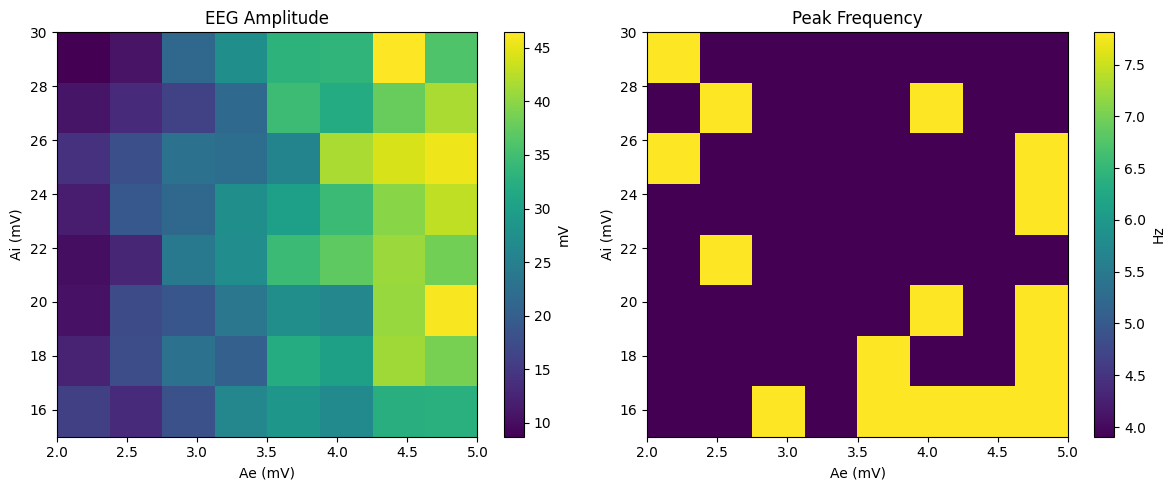

In [11]:
# Parameter grid
Ae_values = np.linspace(2.0, 5.0, 8) * u.mV
Ai_values = np.linspace(15., 30., 8) * u.mV

amplitude_grid = np.zeros((len(Ai_values), len(Ae_values)))
freq_grid = np.zeros((len(Ai_values), len(Ae_values)))

for i, Ai in enumerate(Ai_values):
    for j, Ae in enumerate(Ae_values):
        node = brainmass.JansenRitStep(1, Ae=Ae, Ai=Ai)
        brainstate.nn.init_all_states(node)
        
        def step(inp):
            return node.update(E_inp=inp)
        
        dt = brainstate.environ.get_dt()
        indices = np.arange(int(2 * u.second / dt))
        noise_std = 20. / (float(dt / u.second) ** 0.5)
        inputs = brainstate.random.normal(120., noise_std, indices.shape) * u.Hz
        
        eeg = brainstate.transform.for_loop(step, inputs)
        eeg_ss = np.array(u.get_magnitude(eeg[1000:, 0]))
        
        amplitude_grid[i, j] = eeg_ss.max() - eeg_ss.min()
        
        fs = 1000 / float(dt / u.ms)
        f, Pxx = signal.welch(eeg_ss, fs=fs, nperseg=512)
        peak_idx = np.argmax(Pxx[(f > 3) & (f < 40)])
        freq_grid[i, j] = f[(f > 3) & (f < 40)][peak_idx]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(amplitude_grid, aspect='auto', origin='lower',
                     extent=[float(Ae_values[0]/u.mV), float(Ae_values[-1]/u.mV),
                             float(Ai_values[0]/u.mV), float(Ai_values[-1]/u.mV)])
axes[0].set_xlabel('Ae (mV)')
axes[0].set_ylabel('Ai (mV)')
axes[0].set_title('EEG Amplitude')
plt.colorbar(im1, ax=axes[0], label='mV')

im2 = axes[1].imshow(freq_grid, aspect='auto', origin='lower', cmap='viridis',
                     extent=[float(Ae_values[0]/u.mV), float(Ae_values[-1]/u.mV),
                             float(Ai_values[0]/u.mV), float(Ai_values[-1]/u.mV)])
axes[1].set_xlabel('Ae (mV)')
axes[1].set_ylabel('Ai (mV)')
axes[1].set_title('Peak Frequency')
plt.colorbar(im2, ax=axes[1], label='Hz')

plt.tight_layout()
plt.show()

## Exercises

### Exercise 1: Timescale Separation

Explore the effect of the inhibitory time constant $b_i$:

```python
bi_values = [30., 50., 70., 100., 150.] * u.Hz
# Question: How does slower/faster inhibition affect oscillation frequency?
```

### Exercise 2: Connectivity Constant

The parameter $C$ scales all inter-population connections:

```python
C_values = [50., 100., 135., 200., 300.]
# Question: How does C affect oscillation amplitude and frequency?
```

### Exercise 3: Evoked Response

Simulate an evoked response by applying a brief pulse:

```python
def step_evoked(i):
    t = i * dt
    # Brief pulse at t=500ms
    pulse = 500. * u.Hz if 500*u.ms < t < 510*u.ms else 0. * u.Hz
    baseline_noise = brainstate.random.normal(80., 20.) * u.Hz
    return node.update(E_inp=baseline_noise + pulse)
```

Questions:
1. What does the evoked response look like?
2. How does it depend on Ae and Ai?

## Summary

In this tutorial, you learned:

1. **Three-population architecture**: Pyramidal, excitatory, and inhibitory populations
2. **EEG proxy**: The E-I difference approximates cortical field potentials
3. **Dynamical regimes**: Alpha, spike-wave, disinhibited, and irregular
4. **Parameter effects**: How gains and time constants shape oscillations

### Key Insights

| Regime | Parameters | EEG Character |
|--------|------------|---------------|
| Alpha | Default | 8-12 Hz, regular |
| Spike-wave | High Ae, low Ai, slow bi | Sharp spikes + slow waves |
| Disinhibited | Low Ai | High amplitude |
| Irregular | High input + noise | Broadband |

### Clinical Relevance

The Jansen-Rit model has been used to study:
- Alpha rhythm generation in visual cortex
- Epileptic spike-wave discharges
- Evoked potentials (ERP, VEP)
- Pathological oscillations

### Next Steps

- **Tutorial 022**: Wong-Wang model for decision-making
- **Tutorial 061**: EEG forward model to project cortical activity to sensors
- **Tutorial 070**: Whole-brain modeling with multiple Jansen-Rit columns

## References

1. Jansen, B. H., & Rit, V. G. (1995). Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns. *Biological Cybernetics*, 73(4), 357-366.

2. David, O., & Friston, K. J. (2003). A neural mass model for MEG/EEG: coupling and neuronal dynamics. *NeuroImage*, 20(3), 1743-1755.

3. Wendling, F., Bartolomei, F., Bellanger, J. J., & Chauvel, P. (2002). Epileptic fast activity can be explained by a model of impaired GABAergic dendritic inhibition. *European Journal of Neuroscience*, 15(9), 1499-1508.

4. Grimbert, F., & Faugeras, O. (2006). Bifurcation analysis of Jansen's neural mass model. *Neural Computation*, 18(12), 3052-3068.